In [57]:
from tmm import *
import itertools 
import math
import numpy as np
import pandas as pd
import os
#from tqdm import tqdm
from p_tqdm import p_map
from scipy.spatial.distance import squareform, pdist
import keras
import hashlib

def convert(number:float,type_str:str,convert_str:str,length_unit_in_meter=150e-9,n=1):
    #
    # Utility function for unit conversion
    #
    from math import pi
    k = None # frequency
    l = None # wavelength
    c = 3e8 / n
    a = length_unit_in_meter 
    units_f = {"THz" : 1e-12 * c / a, "Hz" : c / a, "c/a" : 1, "/m" : 2 * pi / a, "/cm" : 2 * pi / a / 100, "/nm" :  2 * pi / a / 1e9, "/a": 2 * pi}
    units_l = {"m" : a, "nm" : 1e9 * a, "a" : 1}
    units = {**units_f, **units_l}
    if (type_str not in units) or (convert_str not in units) : 
        raise NotImplementedError("Unit is not recognized")
    elif (type_str in units_f) == (convert_str in units_f):
        return units[convert_str] / units[type_str] * number
    else :
        return units[convert_str] * units[type_str] / number

def generate_structure(config:dict, params:list):
    return {"d" :  [np.inf, *params, np.inf],
            "n" : [1.0] + ([config["n1"],config["n2"]]*((config["layer_count"]+1)//2))[:config["layer_count"]] + [1.0] }
    
    
def generate_structure_all(config):
    #
    # Define uniform search parameter space, No material dispersion
    #
    resolution = math.ceil(config["simulation_count"] ** (1/config["layer_count"]))
    space_size = resolution ** config["layer_count"]
    ignore_below = 1e-12
    _digits = -math.floor(math.log(ignore_below,10))
    d = [round(x,_digits) for x in np.linspace(config["d_min"],config["d_max"],resolution)]
    params = itertools.product(*([d]*config["layer_count"]))
    for i, p in enumerate(params):
        if i == config["simulation_count"] : break
        yield generate_structure(config, p)

def get_parameter_count(config:dict):
    return config["layer_count"]
def get_parameter_names(config:dict):
    return ['param_'+str(i) for i in range(get_parameter_count(config))]
def get_parameter(structure:dict):
    return structure["d"][1:-1]
    
def calculate_spectrum(structure:dict, ks:list=np.linspace(0.0104720, 0.00628319, num=200)):
    n_list = structure["n"]
    d_list = [x*1e9 for x in structure["d"]]
    spectrum = [coh_tmm('s', n_list, d_list, 0, 1/k)['R'] for k in ks]
    return spectrum
    
def calculate_spectrum_all(config):
    #
    # Precalculate spectrum (forward looking!)
    # row = structure
    # column = wavelength
    #
    filename = f"pkl/sim_{hashlib.md5(str(config).encode()).hexdigest()}.pkl"
    if os.path.isfile(filename):
        df = pd.read_pickle(filename)
    else :
#         structures = generate_structure(config["simulation_count"],layers=config["layer_count"])
        structures = generate_structure_all(config)
        f1 = convert(config["spectral_range"][1], "c/a", "/nm")
        f2 = convert(config["spectral_range"][0], "c/a", "/nm")
        ks = np.linspace(f1, f2, config["spectral_resolution"])
        # results = [ get_parameter(s) + calculate_spectrum(s, ks) for s in tqdm(structures, total = config["simulation_count"])]
        results = p_map(lambda x : get_parameter(x) + calculate_spectrum(x,ks), list(structures))
        columns = get_parameter_names(config) + list(ks)
        df = pd.DataFrame(results, columns = columns)
        df.to_pickle(filename)
    return df

def filter_similar_spectrum(config, df, thres_ratio=0.1, plot=False):
    #
    # Filter spectrum by euclidian distance
    # However it is still overdetermined 
    # 
    assert(0<=thres_ratio<=1)
    assert(df.shape== (config["simulation_count"], get_parameter_count(config) + config["spectral_resolution"]))
    distance = pdist(df.iloc[:,get_parameter_count(config):])
    dist_mat = pd.DataFrame(np.triu(squareform(distance)))
    maxcorr = dist_mat.max()
    thres = np.quantile(maxcorr, thres_ratio)
    if plot:
        import matplotlib.pyplot as plt
        plt.figure()
        plt.matshow(dist_mat, cmap = 'Greys', vmin=0, vmax=1)
        # plt.figure()
        # plt.hist(distance,bins=50)
        # plt.figure()
        # maxcorr.hist(bins=50)
        plt.figure()
        plt.matshow(dist_mat.loc[maxcorr<thres,maxcorr<thres], cmap = 'Greys', vmin=0, vmax=1)
    return df[maxcorr<thres]

def train_test_split(df,ratio):
    train_count = math.floor(df.shape[0] * ratio)
    df.reindex(np.random.permutation(df.index))
    df = df.reindex(np.random.permutation(df.index))
    df_train = df.iloc[:train_count,:]
    df_train.reset_index(inplace=True, drop=True)
    df_test = df.iloc[train_count:,:]
    df_test.reset_index(inplace=True, drop=True)
    return df_train, df_test

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers.experimental.preprocessing import Normalization
import tensorflow as tf

class inverse_model:
    normalizer = Normalization()
    history_forward = None
    history_backward = None
    
    def __init__(self,config):
        self.config = config
        f1 = convert(config["spectral_range"][1], "c/a", "/nm")
        f2 = convert(config["spectral_range"][0], "c/a", "/nm")
        self.ks = np.linspace(f1, f2, config["spectral_resolution"])
        
        self.model_forward = Sequential([
          keras.Input(shape=(get_parameter_count(config))),
          Dense(config["spectral_resolution"], activation='relu'),
          Dense(config["spectral_resolution"]*2.5, activation='relu'),
          Dense(config["spectral_resolution"]),
        ])
        self.model_forward.compile(optimizer='adam',
                        loss=tf.keras.losses.mae,
                        metrics=['accuracy'])

        self.model_backward = Sequential([
          keras.Input(shape=(config["spectral_resolution"])),
          Dense(config["spectral_resolution"]*2.5, activation='relu'),
          Dense(config["spectral_resolution"], activation='relu'),
          Dense(get_parameter_count(config), activation='relu'),
        ] + self.model_forward.layers)
        self.model_backward.compile(optimizer='adam',
                        loss=tf.keras.losses.mae,
                        metrics=['accuracy'])

        self.model_inverse = Sequential([
          keras.Input(shape=(config["spectral_resolution"])) ] 
            + self.model_backward.layers[:-len(self.model_forward.layers)])
        
    
    def summary(self):
        self.model_forward.summary()
        self.model_backward.summary()
        self.model_inverse.summary()
    def freeze(self):
        for l in self.model_forward.layers:
            l.trainable=False

    def train(self,df,train_epochs=10):
        # Prepare data 
        X = df.iloc[:,:get_parameter_count(self.config)]
        Y = df.iloc[:,get_parameter_count(self.config):]

        self.normalizer.adapt(X.values)

        train_ecochs = 10

        # forward train
        self.history_forward = self.model_forward.fit(x=self.normalizer(X), y=Y.values, epochs=train_ecochs)

        # backward train
        self.freeze()
        self.history_backward = self.model_backward.fit(x=Y.values, y=Y.values, epochs=train_ecochs)
    
    def show_history(self):
        import matplotlib.pyplot as plt
        plt.plot(self.history_forward.history['loss'])
        #plt.plot(history_forward.history['val_loss'])
        plt.show()
        plt.plot(self.history_backward.history['loss'])
        #plt.plot(history_backward.history['val_loss'])
        plt.show()
        
    # Inverse design

    def _denormalize(self, tensor):
        output = []
        for x,y,z in zip(
            np.array(self.normalizer.mean),
            np.array(self.normalizer.variance),
            np.array(tensor[0])
        ):
            output.append(x+math.sqrt(y)*z)
        return output

    def design(self, spectrum):
        input_ = tf.reshape(tf.convert_to_tensor(spectrum),(1,self.config["spectral_resolution"]))
        output_ = self._denormalize(self.model_inverse(input_))
#         output_structure = {"d" : [np.inf, *output_, np.inf],
#                      "n": [1.0]+[1.4,2.1]*(len(output_)//2)+[1.0]} 
        output_structure = generate_structure(self.config, output_)
        output_spectrum = calculate_spectrum(output_structure, ks=self.ks)
        return output_structure, output_spectrum

    def test(self,df):
        import random
        test_idx = random.randint(0,df.shape[0]-1)
        input_structure = df.iloc[test_idx,:][:get_parameter_count(self.config)].values
        input_spectrum = df.iloc[test_idx,:][get_parameter_count(self.config):].values
        output_structure, output_spectrum = self.design(input_spectrum)

        print(f"Possible structure : {[round(x*1e9,1) for x in input_structure]}")
        print(f"Output structure : {[round(x*1e9,1) for x in output_structure['d'][1:-1]]}")
        import matplotlib.pyplot as plt
        plt.plot( self.ks,input_spectrum ,self.ks, output_spectrum )

    def save_model(self):
        filename = hashlib.md5(str(self.config).encode()).hexdigest()
        self.model_forward.save('models/model_foward_filename')
        self.model_backward.save('models/model_backward_filename')
        self.model_inverse.save('models/model_inverse_filename')


Epoch 1/10
1/1 [==============================] - 0s 295ms/step - loss: 0.2542 - accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 0.2399 - accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.2258 - accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 6ms/step - loss: 0.2112 - accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 12ms/step - loss: 0.1961 - accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 7ms/step - loss: 0.1808 - accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 6ms/step - loss: 0.1656 - accuracy: 0.0000e+00
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.1518 - accuracy: 0.0000e+00
Epoch 9/10
1/1 [==============================] - 0s 6ms/step - loss: 0.1407 - accuracy: 0.0000e+00
Epoch 10/10
1/1 [==============================] - 0s 8ms/step - loss: 0.1327 - accuracy: 0.0000e

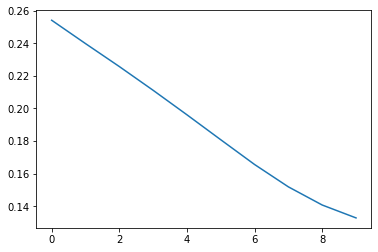

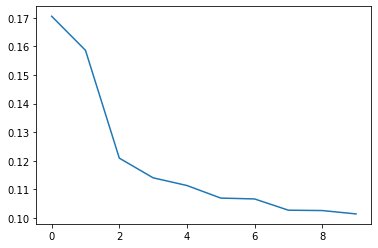

Possible structure : [10.0, 10.0, 56.7, 150.0]
Output structure : [19.3, 96.5, 48.0, 120.2]
INFO:tensorflow:Assets written to: models/model_foward_filename/assets
INFO:tensorflow:Assets written to: models/model_backward_filename/assets
INFO:tensorflow:Assets written to: models/model_inverse_filename/assets


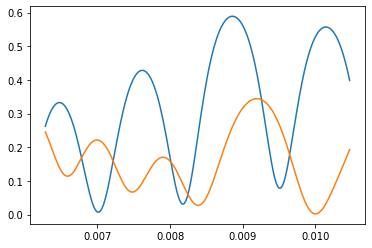

In [67]:
config = {
    "simulation_count" : 100,
    "layer_count" : 4,
    "spectral_range" : (0.15,0.25),
    "spectral_resolution" : 200,
    "n1":1.4,
    "n2":2.1,
    "d_min":10e-9,
    "d_max":150e-9
}
df = calculate_spectrum_all(config)

df = filter_similar_spectrum(config, df, thres_ratio = 0.1, plot=False)

inv = inverse_model(config)
inv.train(df)
inv.show_history()
inv.test(df)
inv.save_model()

In [ ]:
# define model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers.experimental.preprocessing import Normalization
import tensorflow as tf

model_forward = Sequential([
  keras.Input(shape=(get_parameter_count(config))),
  Dense(config["spectral_resolution"], activation='relu'),
  Dense(config["spectral_resolution"]*2.5, activation='relu'),
  Dense(config["spectral_resolution"]),
])
model_forward.summary()
model_forward.compile(optimizer='adam',
                loss=tf.keras.losses.mae,
                metrics=['accuracy'])

model_backward = Sequential([
  keras.Input(shape=(config["spectral_resolution"])),
  Dense(config["spectral_resolution"]*2.5, activation='relu'),
  Dense(config["spectral_resolution"], activation='relu'),
  Dense(get_parameter_count(config), activation='relu'),
] + model_forward.layers)
model_backward.summary()
model_backward.compile(optimizer='adam',
                loss=tf.keras.losses.mae,
                metrics=['accuracy'])

model_inverse = Sequential([
  keras.Input(shape=(config["spectral_resolution"])) ] 
    + model_backward.layers[:-len(model_forward.layers)])
model_inverse.summary()


In [53]:
# Prepare data 
X = df.iloc[:,:get_parameter_count(config)]
Y = df.iloc[:,get_parameter_count(config):]
normalizer = Normalization()
normalizer.adapt(X.values)

train_ecochs = 10

# forward train
history_forward = model_forward.fit(x=normalizer(X), y=Y.values, epochs=train_ecochs)

# backward train
# freeze forward layers
for l in model_forward.layers:
    l.trainable=False
history_backward = model_backward.fit(x=Y.values, y=Y.values, epochs=train_ecochs)


Epoch 1/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0114 - accuracy: 0.1000
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0107 - accuracy: 0.1000
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0094 - accuracy: 0.1000
Epoch 4/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0079 - accuracy: 0.1000
Epoch 5/10
1/1 [==============================] - 0s 15ms/step - loss: 0.0065 - accuracy: 0.1000
Epoch 6/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0062 - accuracy: 0.2000
Epoch 7/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0060 - accuracy: 0.3000
Epoch 8/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0056 - accuracy: 0.2000
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0051 - accuracy: 0.1000
Epoch 10/10
1/1 [==============================] - 0s 12ms/step - loss: 0.0046 - accuracy: 0.2000
Epoch 1/10
1/1 [===================

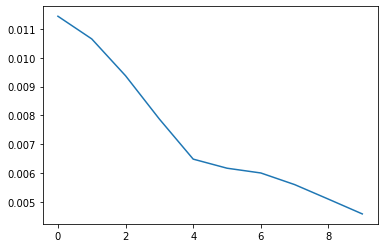

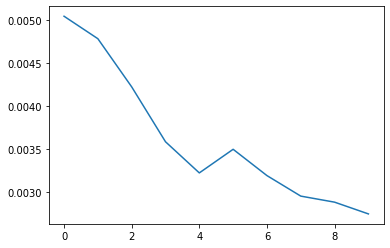

In [54]:
import matplotlib.pyplot as plt
plt.plot(history_forward.history['loss'])
#plt.plot(history_forward.history['val_loss'])
plt.show()
plt.plot(history_backward.history['loss'])
#plt.plot(history_backward.history['val_loss'])
plt.show()

Possible structure : [10.0, 10.0, 10.0, 10.0]
Output structure : [24.5, 45.4, 50.9, 47.0]


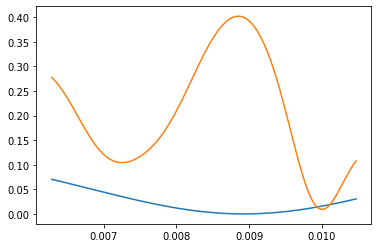

In [57]:
# Inverse design

def denormalize(normalizer, tensor):
    output = []
    for x,y,z in zip(
        np.array(normalizer.mean),
        np.array(normalizer.variance),
        np.array(tensor[0])
    ):
        output.append(x+math.sqrt(y)*z)
    return output

f1 = convert(config["spectral_range"][1], "c/a", "/nm")
f2 = convert(config["spectral_range"][0], "c/a", "/nm")
ks = np.linspace(f1, f2, config["spectral_resolution"])

import random
test_idx = random.randint(0,Y.shape[0])

input_spectrum = Y.iloc[test_idx,:].values
input_ = tf.reshape(tf.convert_to_tensor(input_spectrum),(1,config["spectral_resolution"]))
output_ = denormalize(normalizer, model_inverse(input_))
output_structure = {"d" : [np.inf, *test_output, np.inf],
             "n": [1.0]+[1.4,2.1]*(len(test_output)//2)+[1.0]}
output_spectrum = calculate_spectrum(output_structure, ks=ks)

print(f"Possible structure : {[round(x*1e9,1) for x in X.iloc[test_idx,:].values]}")
print(f"Output structure : {[round(x*1e9,1) for x in test_output]}")
plt.plot( ks,input_spectrum ,ks, output_spectrum )

In [ ]:
# model_forward.save('models/model_foward')
# model_backward.save('models/model_backward')
# model_inverse.save('models/model_inverse')

In [7]:
## tests

def __test_structure():
#     return [
#         [ round(y*1e9) for y in x["d"] if np.isfinite(y)]
#         for x in generate_structure(100,layers=4)
#     ]
    return [ x for x in generate_structure(100,layers=4) ]
        
def __test_tmm():
    f1 = 0.15
    f2 = 0.25
    ks = np.linspace(convert(f2, "c/a", "/nm"), convert(f1, "c/a", "/nm"),200)
    structure = {
        'd': [inf, 1e-08, 5.6667e-08, 1e-08, 5.6667e-08, inf],
        'n': [1.0, 1.4, 1.4, 1.4, 1.4, 1.0]
    }
    import matplotlib.pyplot as plt
    Rnorm = calculate_spectrum(structure, ks)
    plt.plot(ks * 1e7, Rnorm, 'blue')
    return Rnorm
        
def __test_multiple_tmm():
    f1 = 0.15
    f2 = 0.25
    ks = np.linspace(convert(f2, "c/a", "/nm"), convert(f1, "c/a", "/nm"),200)
    a = generate_structure(100,layers=4)
    import matplotlib.pyplot as plt
    [next(a) for x in range(50)]
    Rnorm = calculate_spectrum(next(a), ks)
    plt.plot(ks * 1e7, Rnorm, 'blue')
    plt.xlabel('k (cm$^{-1}$)')
    plt.ylabel('Fraction reflected')
    plt.title('Reflection of unpolarized light at 0$^\circ$ incidence')
    return Rnorm

def __test_simulation():
    config = {
        "simulation_count" : 100,
        "layer_count" : 4,
        "spectral_range" : (0.15,0.25),
        "spectral_resolution" : 200
    }
    df = calculate_spectrum_all(config)
    return df

#__test_structure()
#__test_tmm()
#__test_multiple_tmm()
#__test_simulation()